# Data Preparation (Refactored)

使用 `utils` 中的通用函数，复现原始 `data_prepare.ipynb` 的数据准备与汇总流程，并减少重复代码。

In [11]:
import pandas as pd
import re, os
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from utils import (
    compute_missed_events,
    compute_event_summary,
    clean_questionnaire_block,
    merge_event_and_questionnaire,
    combine_tables_in_dir,
    map_block_numbers_to_labels,
    deduplicate_clicks,
)
import openpyxl
# LMM
import statsmodels.formula.api as smf
from patsy.contrasts import Sum
from itertools import product
# from marginaleffects import *


## Paths & Configuration

In [ ]:
BASE = Path('/Volumes/LYY_T7/13_抽象实验数据分析')
DERIV = BASE / '3_derivatives'
BEHAV = DERIV / 'behavior'
PHYS = DERIV / 'physio'

# Derivative inputs (如存在则读取)
p_blocks_psychopy = BEHAV / 'combined_blocks_final.csv'
p_blocks_ergolab_merged_cleaned = BEHAV / 'blocks_ergolab_merged_cleaned.csv'
p_cleaned_events = BEHAV / 'combined_events_final.csv'
p_cleaned_clicks = BEHAV / 'combined_clicks_final.csv'
p_click_summary = BEHAV / 'clicks_summary.csv'
p_event_summary = BEHAV / 'event_summary.csv'
p_fa_full = BEHAV / 'fa_counts_full.csv'

p_ergolab_contain_block = PHYS / 'ergolab_contain_block.xlsx'
p_ergolab_info_summary = PHYS / 'ergolab_info_summary.csv'

p_que_block_filtered = BEHAV / 'questionnaire_block_cleaned.csv'


# Parameters
TARGETS_PER_BLOCK = 54
RT_OFFSET_SECONDS = 1.3

BEHAV.mkdir(parents=True, exist_ok=True)


## Load Derivative Datasets

In [12]:
def _read_opt(path: Path):
    if path is None:
        return None
    if not path.exists():
        print(f'[skip] Not found: {path}')
        return None
    if path.suffix.lower() in {'.xlsx', '.xls'}:
        df = pd.read_excel(path, sheet_name=0)
    else:
        df = pd.read_csv(path)
    print(f'[load] {path} shape={df.shape}')
    return df

blocks_psychopy = _read_opt(p_blocks_psychopy)
blocks_ergolab_merged_cleaned = _read_opt(p_blocks_ergolab_merged_cleaned)
cleaned_events = _read_opt(p_cleaned_events)
ergolab_contain_block = _read_opt(p_ergolab_contain_block)
ergolab_info_summary = _read_opt(p_ergolab_info_summary)
cleaned_clicks = _read_opt(p_cleaned_clicks)
event_summary = _read_opt(p_event_summary)
clicks_summary = _read_opt(p_click_summary)
fa_full = _read_opt(p_fa_full)
que_block_filtered = _read_opt(p_que_block_filtered)

# 得到block所有信息的汇总表格
blocks_ergolab_merged_cleaned['participant_id'] = pd.to_numeric(blocks_ergolab_merged_cleaned['participant_id'], errors='coerce').astype('Int64') # pyright: ignore[reportOptionalSubscript]
blocks_summary = blocks_ergolab_merged_cleaned.merge(clicks_summary, on=["participant_id", "block_label"], how="left")
blocks_summary = blocks_summary.merge(event_summary, on=["participant_id", "block_label"], how="left")
blocks_summary = blocks_summary.merge(fa_full, on=["participant_id", "block_label"], how="left")
blocks_summary = blocks_summary.merge(que_block_filtered,on=["participant_id", "block_label"], how="left")


# 重新安排列的顺序
blocks_summary = blocks_summary[[
    # 标识符
    "participant_id", "block_label", 
    # 程序时间
    "exp_start_time",  "abs_onset_time", "abs_offset_time", "onset_time", "offset_time", "duration",
    # ergolab项目时间相关数据
    "create_time", "recording",
    # 行为指标
    "click_count", "is_hit", "hit_rate", "Reaction_time", "fa_count", "disturbance_count","fa_rate",
    # 主观指标
    "mental_demand", "physical_demand", "temporal_demand", "effort", "frustration", "performance", "SSS", "perceived_difficulty"
]]
# 给部分列重命名
blocks_summary = blocks_summary.rename(columns={
    "create_time": "ergolab_create_time",
    "recording": "ergolab_recording",
    "is_hit": "hit_count",
    "disturbance_count": "n_noise"
})
# 行根据participant_id 和 block_label排序
blocks_summary = blocks_summary.sort_values(by=["participant_id", "block_label"], kind="mergesort")

# 部分行数据错误
mask = (blocks_summary["participant_id"] == 38) & (blocks_summary["block_label"] == "G")
blocks_summary.loc[mask, 'hit_rate'] = 51 / 54
blocks_summary.loc[mask, 'hit_count'] = 51


out_blocks = BEHAV / 'blocks_summary.csv'
blocks_summary.to_csv(out_blocks, index=False)
print(f'[save] {out_blocks}')


[load] /Volumes/LYY_T7/13_抽象实验数据分析/3_derivatives/behavior/combined_blocks_final.csv shape=(279, 10)
[load] /Volumes/LYY_T7/13_抽象实验数据分析/3_derivatives/behavior/blocks_ergolab_merged_cleaned.csv shape=(280, 12)
[load] /Volumes/LYY_T7/13_抽象实验数据分析/3_derivatives/behavior/combined_events_final.csv shape=(15080, 14)
[load] /Volumes/LYY_T7/13_抽象实验数据分析/3_derivatives/physio/ergolab_contain_block.xlsx shape=(304, 3)
[load] /Volumes/LYY_T7/13_抽象实验数据分析/3_derivatives/physio/ergolab_info_summary.csv shape=(50, 3)
[load] /Volumes/LYY_T7/13_抽象实验数据分析/3_derivatives/behavior/combined_clicks_final_dedup.csv shape=(15182, 15)
[load] /Volumes/LYY_T7/13_抽象实验数据分析/3_derivatives/behavior/event_summary.csv shape=(279, 5)
[load] /Volumes/LYY_T7/13_抽象实验数据分析/3_derivatives/behavior/clicks_summary.csv shape=(279, 3)
[load] /Volumes/LYY_T7/13_抽象实验数据分析/3_derivatives/behavior/fa_counts_full.csv shape=(304, 6)
[load] /Volumes/LYY_T7/13_抽象实验数据分析/3_derivatives/behavior/questionnaire_block_cleaned.csv shape=(279, 10)
[save] /

# 被试信息

In [13]:
participants_raw1 = _read_opt(BASE / '1_rawdata/questionnaire/318349230_按序号_实验前测问卷_43_43.xlsx')
participants_raw2 = _read_opt(BASE / '1_rawdata/questionnaire/324462240_按序号_实验后测问卷_35_35.xlsx')


[load] /Volumes/LYY_T7/13_抽象实验数据分析/1_rawdata/questionnaire/318349230_按序号_实验前测问卷_43_43.xlsx shape=(38, 30)
[load] /Volumes/LYY_T7/13_抽象实验数据分析/1_rawdata/questionnaire/324462240_按序号_实验后测问卷_35_35.xlsx shape=(35, 16)


In [14]:
from acs_scoring import score_acs  # 上一步已提供的脚本
from risk_propensity_scoring import score_rps, demographics_summary

att_scored, att_mapping = score_acs(participants_raw1, scale_max=4)
rps_scored, rps_mapping = score_rps(participants_raw2, scale_max=5)
rps_scored = rps_scored.loc[:, ~rps_scored.columns.duplicated()]

participants_info = att_scored.merge(rps_scored, on="subject_id", suffixes=("_att", "_rps"))

# === B) 剔除被试 9、25、26、37 ===
sid = pd.to_numeric(participants_info["subject_id"], errors="coerce")
scored_filtered = participants_info[~sid.isin([9, 25, 26, 37])].copy()

# === C) 标准化性别值（兼容 男/女/Male/Female/M/F 等）===
sex_map = {
    "男":"男","male":"男","Male":"男","M":"男","m":"男",
    "女":"女","female":"女","Female":"女","F":"女","f":"女"
}
scored_filtered["sex_std"] = (
    scored_filtered["sex"]
    .astype(str).str.strip()
    .map(lambda x: sex_map.get(x, x))
)

# === D) 计算男女比例 ===
n = len(scored_filtered)
sex_counts = scored_filtered["sex_std"].value_counts(dropna=False)
sex_pct = (sex_counts / n * 100).round(1)

male_n = int(sex_counts.get("男", 0))
female_n = int(sex_counts.get("女", 0))
male_pct = float(sex_pct.get("男", 0.0))
female_pct = float(sex_pct.get("女", 0.0))

print(f"样本量（剔除后）：{n}")
print(f"男：{male_n} 人（{male_pct}%）")
print(f"女：{female_n} 人（{female_pct}%）")

# 若存在其他/缺失的性别项，也一并输出
others = sex_counts.drop(labels=["男","女"], errors="ignore")
if len(others) > 0:
    for k, v in others.items():
        print(f"{k}：{v} 人（{float(sex_pct.get(k, 0.0))}%）")

# === E) 年龄的均值和标准差（忽略缺失） ===
age = pd.to_numeric(scored_filtered["age"], errors="coerce")
age_mean = age.mean()
age_std = age.std(ddof=1)  # 样本标准差

print(f"年龄：均值 = {age_mean:.2f}，标准差 = {age_std:.2f}")

participants_info_clean = participants_info[["subject_id", "RPS_total","RPS_mean",'ACS_total', 'ACS_focusing', 'ACS_shifting']]
participants_info_clean.to_csv(BEHAV / 'participants_info_clean.csv', index=False)


样本量（剔除后）：33
男：0 人（0.0%）
女：0 人（0.0%）
2：20 人（60.6%）
1：13 人（39.4%）
年龄：均值 = 25.39，标准差 = 2.77


In [15]:
# 合并被试基础信息与 RPS 得分，仅保留核心字段
id_candidates = (
    "participant_id", "subject_id", "被试编号", "编号", "participant", "id", "ID"
)
sex_candidates = ("sex", "性别", "gender", "Sex", "Gender")
age_candidates = ("age", "年龄", "年龄（岁）", "age_years", "Age")
score_candidates = ("RPS_total", "RPS_mean", "score", "总分", "得分")


def _rename_first(df, candidates, target):
    for col in candidates:
        if col in df.columns:
            if col != target:
                df = df.rename(columns={col: target})
            return df
    raise KeyError(f"未找到 {target} 对应的列，候选: {candidates}")


def _normalize_id(series: pd.Series) -> pd.Series:
    s = series.astype(str).str.strip()
    s = s.str.extract(r"(\d+)")[0]
    out = pd.to_numeric(s, errors="coerce")
    return out.astype("Int64")


def _normalize_sex(series: pd.Series) -> pd.Series:
    mapping = {
        "男": "男", "male": "男", "Male": "男", "MALE": "男", "M": "男", "m": "男", "男生": "男",
        "女": "女", "female": "女", "Female": "女", "FEMALE": "女", "F": "女", "f": "女", "女生": "女",
    }
    s = series.astype(str).str.strip()
    s = s.replace(mapping)
    s = s.replace({"nan": pd.NA, "": pd.NA})
    return s


def _prepare_info(df: pd.DataFrame) -> pd.DataFrame:
    info = df.copy()
    info = _rename_first(info, id_candidates, "participant_id")
    info["participant_id"] = _normalize_id(info["participant_id"])
    info = info.dropna(subset=["participant_id"])
    info = info.drop_duplicates("participant_id", keep="last")

    sex_col_found = False
    for col in sex_candidates:
        if col in info.columns:
            if col != "sex":
                info = info.rename(columns={col: "sex"})
            sex_col_found = True
            break
    if not sex_col_found:
        info["sex"] = pd.NA
    info["sex"] = _normalize_sex(info["sex"])

    age_col_found = False
    for col in age_candidates:
        if col in info.columns:
            if col != "age":
                info = info.rename(columns={col: "age"})
            age_col_found = True
            break
    if not age_col_found:
        info["age"] = pd.NA
    info["age"] = pd.to_numeric(info["age"], errors="coerce")

    return info[["participant_id", "sex", "age"]]


def _prepare_rps(df: pd.DataFrame) -> pd.DataFrame:
    rps = df.copy()
    rps = _rename_first(rps, id_candidates, "participant_id")
    rps["participant_id"] = _normalize_id(rps["participant_id"])
    rps = rps.dropna(subset=["participant_id"])
    rps = rps.drop_duplicates("participant_id", keep="last")

    score_col = next((c for c in score_candidates if c in rps.columns), None)
    if score_col is None:
        raise KeyError(f"未找到 RPS 得分列，候选: {score_candidates}")
    rps = rps.rename(columns={score_col: "score"})
    rps["score"] = pd.to_numeric(rps["score"], errors="coerce")

    return rps[["participant_id", "score"]]


participants_info_clean = _prepare_info(participants_info)
rps_scored_clean = _prepare_rps(rps_scored)

participants_rps = participants_info_clean.merge(
    rps_scored_clean, on="participant_id", how="inner"
).sort_values("participant_id").reset_index(drop=True)

participants_rps = participants_rps.rename(columns={
    "participant_id": "被试编号",
    "sex": "性别",
    "age": "年龄",
    "score": "得分",
})

participants_rps = participants_rps[["被试编号", "性别", "年龄", "得分"]]
participants_rps


,被试编号,性别,年龄,得分
0,1,1,26,24
1,2,1,26,28
2,3,1,23,21
3,4,1,24,21
4,5,2,21,29
5,6,2,27,17
6,7,1,32,25
7,8,2,22,23
8,10,2,21,31
9,11,2,27,24


# 指标计算

## SDT 指标计算以及矫正

In [17]:
import scipy.stats as stats

def compute_d_prime(row, n_signal = 54):
    # 修正
    hit_rate = (row['hit_count'] + 0.5) / (n_signal + 1)
    fa_rate = (row['fa_count'] + 0.5) / (row['n_noise'] + 1)
    # z-score
    z_hit = stats.norm.ppf(hit_rate)
    z_fa = stats.norm.ppf(fa_rate)
    d_prime = z_hit - z_fa
    c = -0.5 * (z_hit + z_fa)
    return pd.Series({'hit_rate_re': hit_rate, 'fa_rate_re': fa_rate, 'd_prime': d_prime, 'c': c})

blocks_summary[['hit_rate_re', 'fa_rate_re', 'd_prime', 'c']] = blocks_summary.apply(compute_d_prime, axis=1)
blocks_summary

,participant_id,block_label,exp_start_time,abs_onset_time,abs_offset_time,onset_time,offset_time,duration,ergolab_create_time,ergolab_recording,...,temporal_demand,effort,frustration,performance,SSS,perceived_difficulty,hit_rate_re,fa_rate_re,d_prime,c
8,1,A,2025-07-22 13:45:57.389,2025-07-22 13:48:29.483819100,2025-07-22 13:54:31.467702000,152.094819,514.078702,361.983883,2025-07-22 13:42:01.581,R1,...,19.0,35.0,37.0,77.0,4.0,3.0,0.918182,0.013975,3.590928,0.402519
9,1,B,2025-07-22 13:45:57.389,2025-07-22 13:56:31.232449200,2025-07-22 14:02:33.211943100,633.843449,995.822943,361.979494,2025-07-22 13:42:01.581,R1,...,23.0,40.0,30.0,80.0,3.0,5.0,0.990909,0.001543,5.320892,0.298551
10,1,C,2025-07-22 14:13:31.431,2025-07-22 14:29:41.376233000,2025-07-22 14:35:43.352902000,969.945233,1331.921902,361.976669,2025-07-22 14:13:15.901,R2,...,16.0,41.0,25.0,83.0,3.0,2.0,0.954545,0.004373,4.312434,0.465595
11,1,D,2025-07-22 14:39:56.601,2025-07-22 14:52:47.663034200,2025-07-22 14:58:49.642241600,771.062034,1133.041242,361.979207,2025-07-22 14:39:42.059,R3,...,18.0,36.0,21.0,86.0,2.0,2.0,0.972727,0.007440,4.357743,0.256392
12,1,E,2025-07-22 15:01:08.005,2025-07-22 15:14:19.449769700,2025-07-22 15:25:32.426622100,791.444770,1464.421622,672.976852,2025-07-22 14:39:42.059,R3,...,15.0,33.0,15.0,82.0,2.0,2.0,0.990909,0.002340,5.190154,0.233182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,38,D,2025-07-30 13:39:14.258,2025-07-30 13:41:45.211267900,2025-07-30 13:47:47.186707300,150.953268,512.928707,361.975439,2025-07-30 13:33:59.529,R1,...,75.0,80.0,35.0,75.0,2.0,5.0,0.881818,0.019345,3.251589,0.441669
276,38,E,2025-07-30 14:02:32.576,2025-07-30 14:02:49.419636500,2025-07-30 14:14:02.393826700,16.843637,689.817827,672.974190,2025-07-30 13:33:59.529,R1,...,25.0,70.0,30.0,88.0,3.0,2.0,0.936364,0.007020,3.981169,0.465639
277,38,F,2025-07-30 13:39:14.258,2025-07-30 13:49:55.071123900,2025-07-30 14:01:08.042298800,640.813124,1313.784299,672.971175,2025-07-30 13:33:59.529,R1,...,40.0,75.0,35.0,85.0,2.0,3.0,0.900000,0.006988,3.739453,0.588175
7,38,G,2025-07-30 15:07:48.381,2025-07-30 15:08:00.297901400,2025-07-30 15:19:13.281365300,11.916901,684.900365,672.983464,2025-07-30 15:07:30.738,R2,...,45.0,65.0,50.0,85.0,3.0,3.0,0.936364,0.003823,4.192293,0.571201


## Block Factors Mapping and Overview Plots

In [18]:
# Define mapping from block_label to three factors
BLOCK_FACTORS = {
    'A': {'event_freq': 'high', 'risk_type': 'slow_risk', 'visual_consistency': 'consistent'},
    'B': {'event_freq': 'high', 'risk_type': 'slow_risk', 'visual_consistency': 'inconsistent'},
    'C': {'event_freq': 'high', 'risk_type': 'fast_risk', 'visual_consistency': 'consistent'},
    'D': {'event_freq': 'high', 'risk_type': 'fast_risk', 'visual_consistency': 'inconsistent'},
    'E': {'event_freq': 'low', 'risk_type': 'slow_risk', 'visual_consistency': 'consistent'},
    'F': {'event_freq': 'low', 'risk_type': 'slow_risk', 'visual_consistency': 'inconsistent'},
    'G': {'event_freq': 'low', 'risk_type': 'fast_risk', 'visual_consistency': 'consistent'},
    'H': {'event_freq': 'low', 'risk_type': 'fast_risk', 'visual_consistency': 'inconsistent'},
}
BLOCK_ORDER = list('ABCDEFGH')

def add_block_factors(df):
    out = df.copy()
    out['block_label'] = out['block_label'].astype(str)
    out['block_label'] = pd.Categorical(out['block_label'], categories=BLOCK_ORDER, ordered=True)
    out['event_freq'] = out['block_label'].map(lambda b: BLOCK_FACTORS[str(b)]['event_freq'])
    out['risk_type'] = out['block_label'].map(lambda b: BLOCK_FACTORS[str(b)]['risk_type'])
    out['visual_consistency'] = out['block_label'].map(lambda b: BLOCK_FACTORS[str(b)]['visual_consistency'])
    for c in ['event_freq','risk_type','visual_consistency']:
        out[c] = out[c].astype('category')
    return out

analysis_df = add_block_factors(blocks_summary)


# 探索性分析

- 因变量
    - 行为指标('hit_rate', 'Reaction_time','fa_rate','d_prime', 'c')
    - 生理指标()
    - 主观指标('mental_demand', 'physical_demand', 'temporal_demand', 'effort','frustration', 'performance', 'SSS', 'perceived_difficulty',)
    - 眼动指标（还没有导出）
- 自变量 
    - event_freq
    - risk_type
    - visual_consistency
- 随机效应
    - 被试间的差异
    - 随机差异

- 单因素趋势图
    - Boxplot / violin plot / stripplot
    - 例：每个 event_freq 下 d_prime 的分布
- 多因素交互可视化
	- 使用 facetgrid 或 hue 表示多因素
	- 例：x轴为 risk_type, hue 为 visual_consistency, 每个 event_freq 一个子图
- 主观指标可视化
	- 将 NASA-TLX 六个指标 reshape 为 long format
	- 用 雷达图 / grouped bar chart 比较不同 block 条

## 前期准备
类别型自变量 → category

因变量 → 浮点型，检查异常值

对 fa_rate 或比例类 DV，考虑 Hautus 修正 或 logit/arcsin sqrt 转换

In [22]:
cat_vers = ["event_freq", "risk_type", "visual_consistency", "block_label"]
for c in cat_vers:
    analysis_df[c] = analysis_df[c].astype("category")
analysis_df.columns


Index(['participant_id', 'block_label', 'exp_start_time', 'abs_onset_time',
       'abs_offset_time', 'onset_time', 'offset_time', 'duration',
       'ergolab_create_time', 'ergolab_recording', 'click_count', 'hit_count',
       'hit_rate', 'Reaction_time', 'fa_count', 'n_noise', 'fa_rate',
       'mental_demand', 'physical_demand', 'temporal_demand', 'effort',
       'frustration', 'performance', 'SSS', 'perceived_difficulty',
       'hit_rate_re', 'fa_rate_re', 'd_prime', 'c', 'event_freq', 'risk_type',
       'visual_consistency', 'hit_rate_arcsin', 'fa_rate_arcsin'],
      dtype='object')

## 画图
画直方图 / qqplot

对严重偏态的 DV 做转换（log / sqrt / arcsin）

/Users/liyanyi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


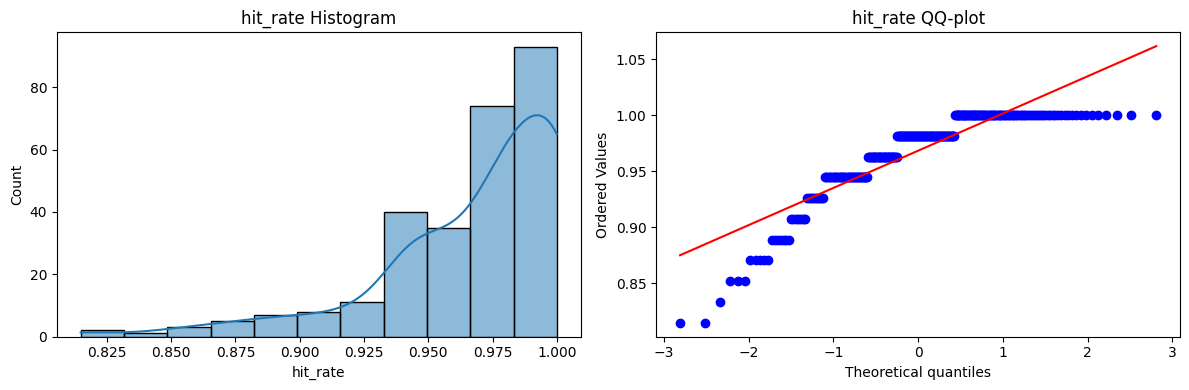

/Users/liyanyi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


hit_rate - Skewness: -1.640, Kurtosis: 2.912


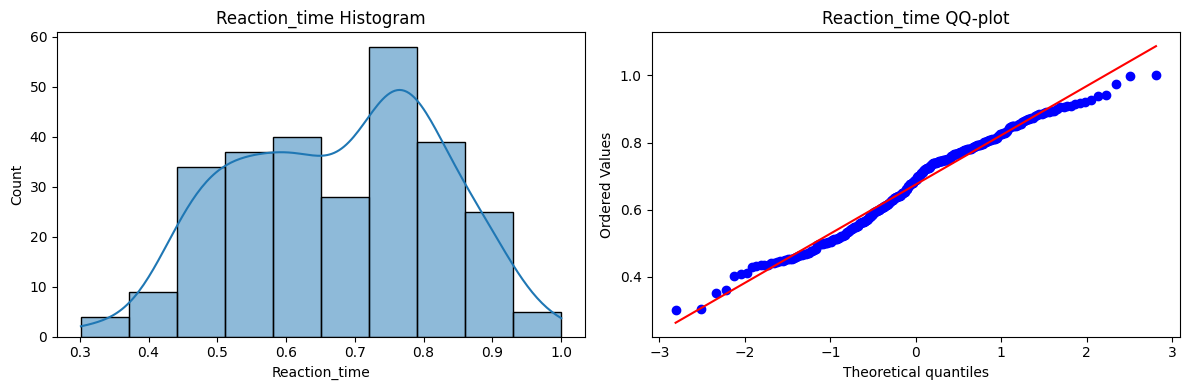

Reaction_time - Skewness: -0.153, Kurtosis: -0.815


/Users/liyanyi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


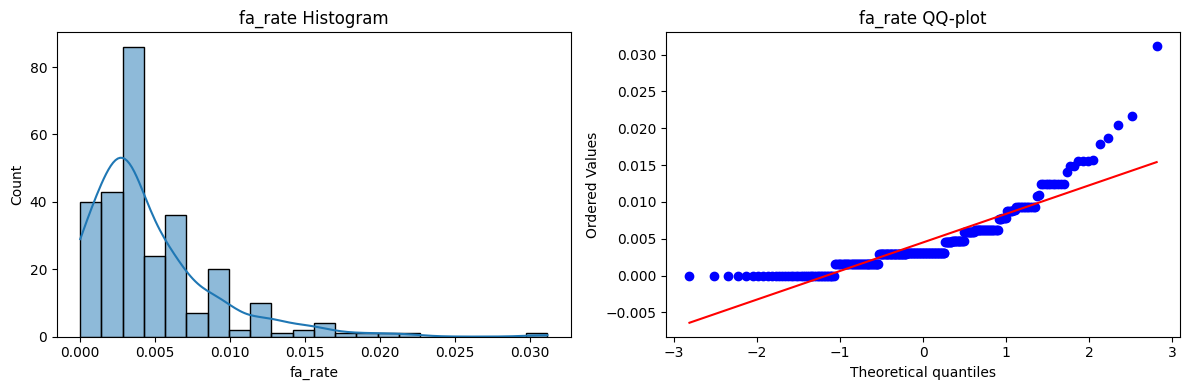

fa_rate - Skewness: 2.060, Kurtosis: 6.708


/Users/liyanyi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


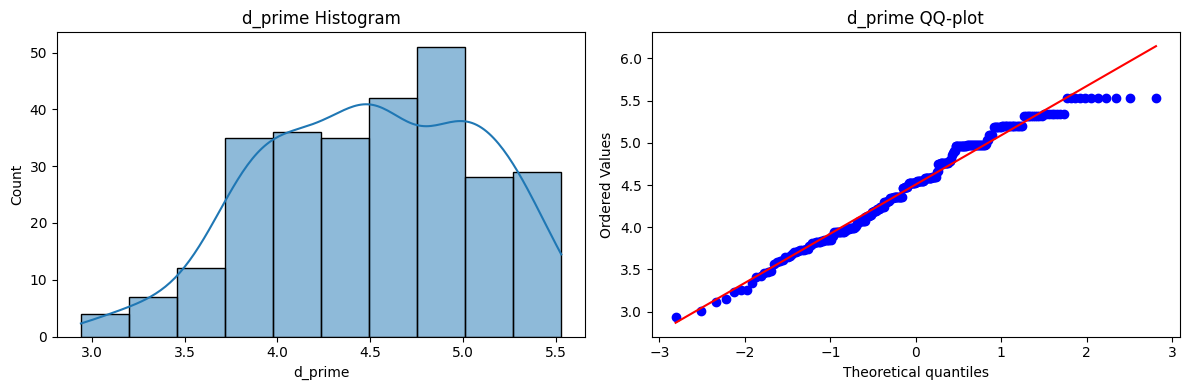

d_prime - Skewness: -0.213, Kurtosis: -0.673


/Users/liyanyi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


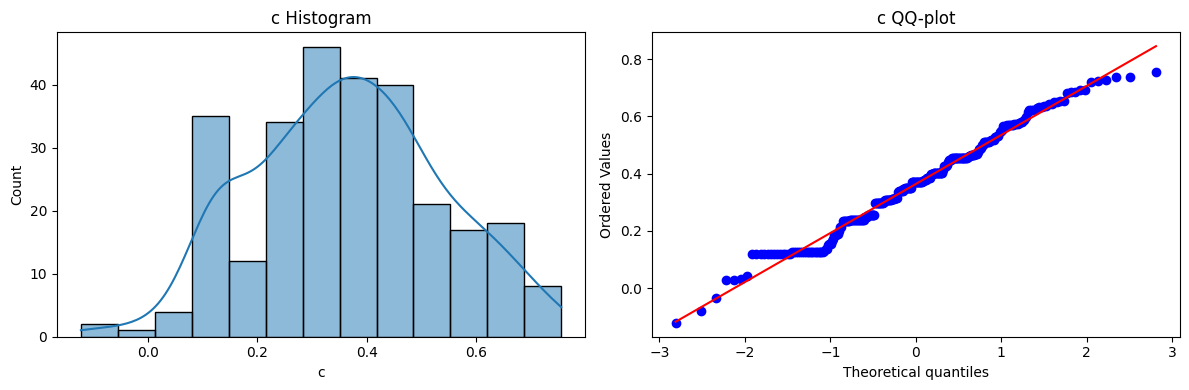

c - Skewness: 0.019, Kurtosis: -0.435


/Users/liyanyi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


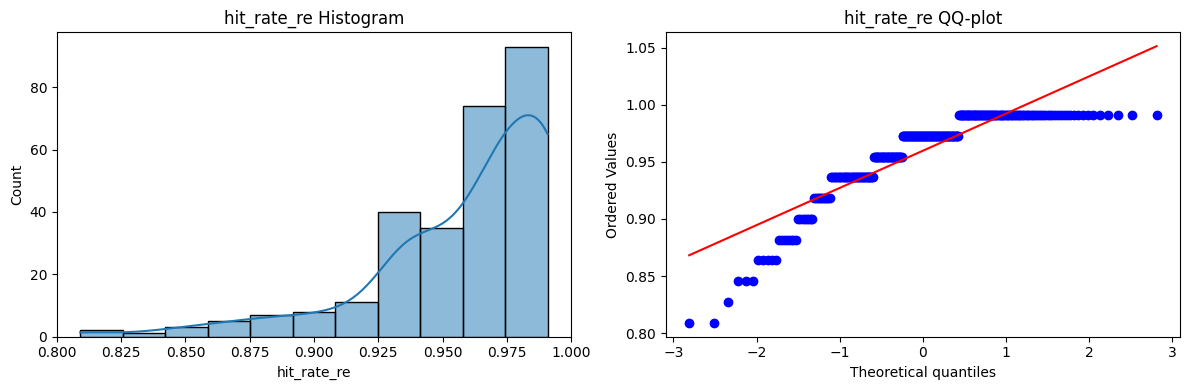

hit_rate_re - Skewness: -1.640, Kurtosis: 2.912


/Users/liyanyi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


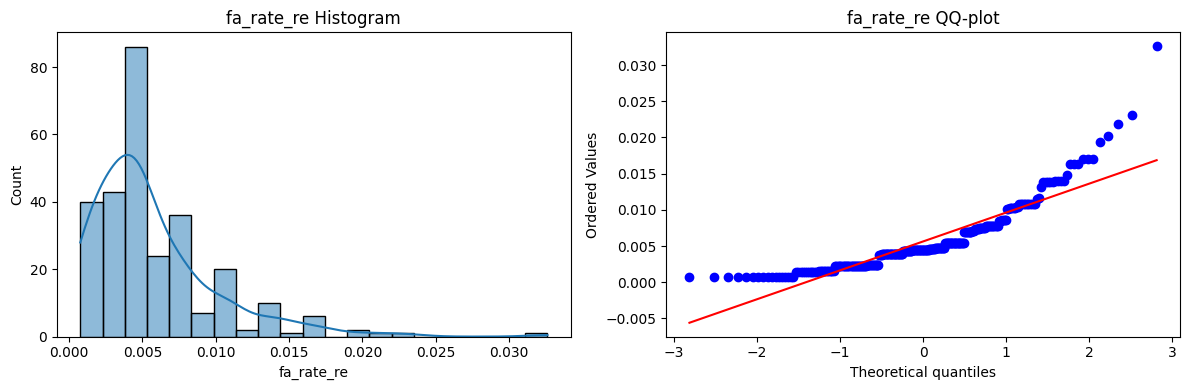

fa_rate_re - Skewness: 2.031, Kurtosis: 6.447


In [7]:
DV_beha = ['hit_rate', 'Reaction_time','fa_rate','d_prime', 'c','hit_rate_re','fa_rate_re']
for dv in DV_beha:
    analysis_df[dv] = pd.to_numeric(analysis_df[dv],errors='coerce')

    
for dv in DV_beha:
    fig, axes = plt.subplots(1, 2, figsize = (12,4))
    # 直方图
    sns.histplot(analysis_df[dv].dropna(), kde=True, ax=axes[0])
    axes[0].set_title(f'{dv} Histogram')

    # QQ-plot
    stats.probplot(analysis_df[dv].dropna(), dist="norm", plot=axes[1])
    axes[1].set_title(f'{dv} QQ-plot')

    plt.tight_layout()
    plt.show()

    # 简单偏态指标
    skewness = analysis_df[dv].dropna().skew()
    kurtosis = analysis_df[dv].dropna().kurtosis()
    print(f'{dv} - Skewness: {skewness:.3f}, Kurtosis: {kurtosis:.3f}')



In [20]:
# hit_rate 和 fa_rate 在 0~1 范围内
analysis_df['hit_rate_arcsin'] = np.arcsin(np.sqrt(analysis_df['hit_rate']))
analysis_df['fa_rate_arcsin'] = np.arcsin(np.sqrt(analysis_df['fa_rate']))
analysis_df

,participant_id,block_label,exp_start_time,abs_onset_time,abs_offset_time,onset_time,offset_time,duration,ergolab_create_time,ergolab_recording,...,perceived_difficulty,hit_rate_re,fa_rate_re,d_prime,c,event_freq,risk_type,visual_consistency,hit_rate_arcsin,fa_rate_arcsin
8,1,A,2025-07-22 13:45:57.389,2025-07-22 13:48:29.483819100,2025-07-22 13:54:31.467702000,152.094819,514.078702,361.983883,2025-07-22 13:42:01.581,R1,...,3.0,0.918182,0.013975,3.590928,0.402519,high,slow_risk,consistent,1.295154,0.111862
9,1,B,2025-07-22 13:45:57.389,2025-07-22 13:56:31.232449200,2025-07-22 14:02:33.211943100,633.843449,995.822943,361.979494,2025-07-22 13:42:01.581,R1,...,5.0,0.990909,0.001543,5.320892,0.298551,high,slow_risk,inconsistent,1.570796,0.000000
10,1,C,2025-07-22 14:13:31.431,2025-07-22 14:29:41.376233000,2025-07-22 14:35:43.352902000,969.945233,1331.921902,361.976669,2025-07-22 14:13:15.901,R2,...,2.0,0.954545,0.004373,4.312434,0.465595,high,fast_risk,consistent,1.377138,0.054100
11,1,D,2025-07-22 14:39:56.601,2025-07-22 14:52:47.663034200,2025-07-22 14:58:49.642241600,771.062034,1133.041242,361.979207,2025-07-22 14:39:42.059,R3,...,2.0,0.972727,0.007440,4.357743,0.256392,high,fast_risk,inconsistent,1.434290,0.077344
12,1,E,2025-07-22 15:01:08.005,2025-07-22 15:14:19.449769700,2025-07-22 15:25:32.426622100,791.444770,1464.421622,672.976852,2025-07-22 14:39:42.059,R3,...,2.0,0.990909,0.002340,5.190154,0.233182,low,slow_risk,consistent,1.570796,0.039539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,38,D,2025-07-30 13:39:14.258,2025-07-30 13:41:45.211267900,2025-07-30 13:47:47.186707300,150.953268,512.928707,361.975439,2025-07-30 13:33:59.529,R1,...,5.0,0.881818,0.019345,3.251589,0.441669,high,fast_risk,inconsistent,1.230959,0.134233
276,38,E,2025-07-30 14:02:32.576,2025-07-30 14:02:49.419636500,2025-07-30 14:14:02.393826700,16.843637,689.817827,672.974190,2025-07-30 13:33:59.529,R1,...,2.0,0.936364,0.007020,3.981169,0.465639,low,slow_risk,consistent,1.332855,0.079140
277,38,F,2025-07-30 13:39:14.258,2025-07-30 13:49:55.071123900,2025-07-30 14:01:08.042298800,640.813124,1313.784299,672.971175,2025-07-30 13:33:59.529,R1,...,3.0,0.900000,0.006988,3.739453,0.588175,low,slow_risk,inconsistent,1.261603,0.078954
7,38,G,2025-07-30 15:07:48.381,2025-07-30 15:08:00.297901400,2025-07-30 15:19:13.281365300,11.916901,684.900365,672.983464,2025-07-30 15:07:30.738,R2,...,3.0,0.936364,0.003823,4.192293,0.571201,low,fast_risk,consistent,1.332855,0.055371


/Users/liyanyi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


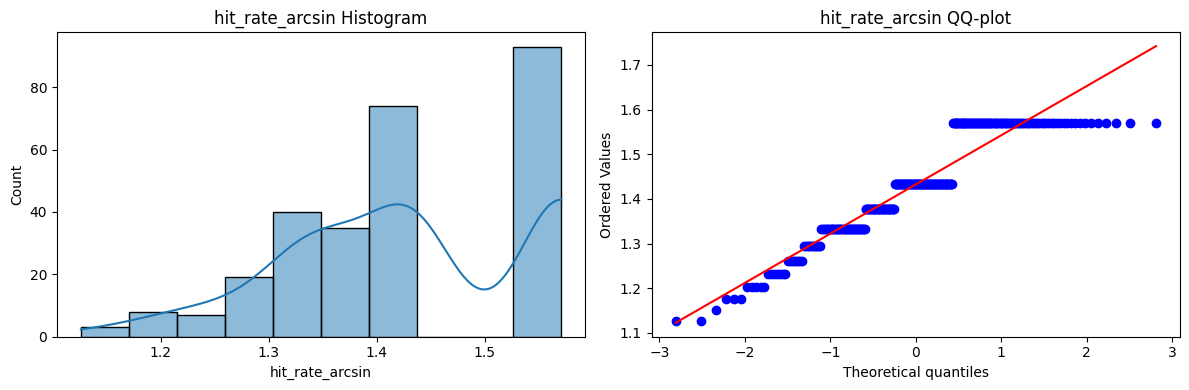

hit_rate_arcsin - Skewness: -0.269, Kurtosis: -0.765


/Users/liyanyi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


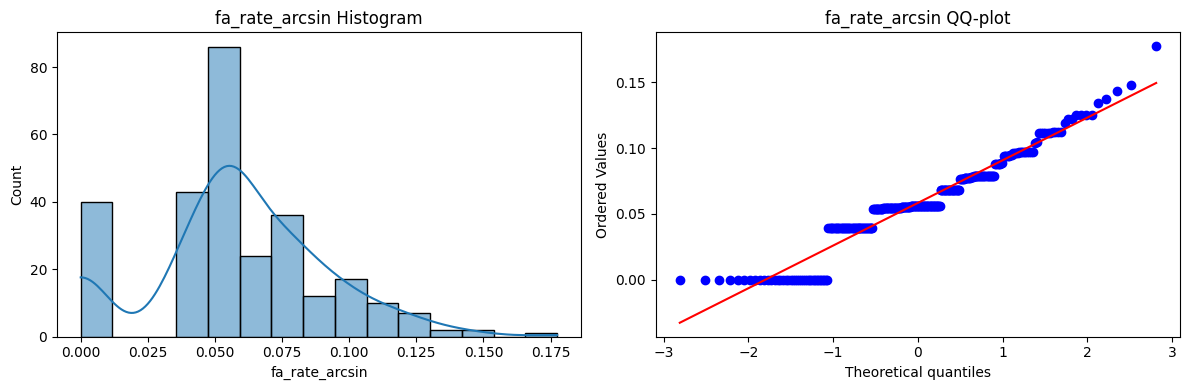

fa_rate_arcsin - Skewness: 0.084, Kurtosis: 0.365


In [9]:
DV_beha = ['hit_rate_arcsin','fa_rate_arcsin']
for dv in DV_beha:
    fig, axes = plt.subplots(1, 2, figsize = (12,4))
    # 直方图
    sns.histplot(analysis_df[dv].dropna(), kde=True, ax=axes[0])
    axes[0].set_title(f'{dv} Histogram')

    # QQ-plot
    stats.probplot(analysis_df[dv].dropna(), dist="norm", plot=axes[1])
    axes[1].set_title(f'{dv} QQ-plot')

    plt.tight_layout()
    plt.show()

    # 简单偏态指标
    skewness = analysis_df[dv].dropna().skew()
    kurtosis = analysis_df[dv].dropna().kurtosis()
    print(f'{dv} - Skewness: {skewness:.3f}, Kurtosis: {kurtosis:.3f}')



## Assumption Checks

In [10]:
from scipy import stats
import statsmodels.formula.api as smf

def prepare_rm_df(df: pd.DataFrame, metric: str) -> pd.DataFrame:
    cols = ['participant_id','event_freq','risk_type','visual_consistency', metric]
    sub = df[cols].dropna().copy()
    # Cast dtypes for statsmodels/patsy compatibility
    sub['participant_id'] = pd.to_numeric(sub['participant_id'], errors='coerce').astype('int64')
    sub[metric] = pd.to_numeric(sub[metric], errors='coerce').astype('float64')
    sub['event_freq'] = pd.Categorical(sub['event_freq'], categories=['低','高'], ordered=True)
    sub['risk_type'] = pd.Categorical(sub['risk_type'], categories=['缓变','突变'], ordered=True)
    sub['visual_consistency'] = pd.Categorical(sub['visual_consistency'], categories=['同方向','不同方向'], ordered=True)
    cnt = sub.groupby('participant_id')[metric].count()
    full_ids = cnt[cnt >= 8].index
    sub = sub[sub['participant_id'].isin(full_ids)]
    return sub

def check_assumptions_rm(df: pd.DataFrame, metric: str):
    sub = prepare_rm_df(df, metric)
    n_subj = int(sub['participant_id'].nunique())
    if n_subj < 2:
        return {'metric': metric, 'ok': False, 'reason': 'too_few_subjects', 'n_subj': n_subj}
    # OLS with subject fixed effects to obtain residuals
    formula = f"{metric} ~ C(participant_id) + C(event_freq)*C(risk_type)*C(visual_consistency)"
    try:
        model = smf.ols(formula, data=sub).fit()
        resid = model.resid.dropna()
    except Exception as e:
        # Fallback: within-subject de-meaning residuals if OLS fails (e.g., design singular/empty)
        resid = (sub[metric] - sub.groupby('participant_id')[metric].transform('mean')).dropna()
    if len(resid) >= 3 and len(resid) <= 5000:
        W, p = stats.shapiro(resid)
    else:
        W, p = float('nan'), float('nan')
    z = (resid - resid.mean()) / resid.std(ddof=1)
    outliers = int((z.abs() > 3).sum())
    return {'metric': metric, 'ok': True, 'n_subj': n_subj, 'n_rows': int(len(sub)), 'shapiro_W': float(W) if W==W else None, 'shapiro_p': float(p) if p==p else None, 'outliers>|3z|': outliers}

assump_rows = []
if 'analysis_df' in globals() and analysis_df is not None:
    metrics_all = ['click_count','hit_rate','Reaction_time','fa_count','mental_demand','physical_demand','temporal_demand','effort','frustration','performance','SSS','perceived_difficulty']
    metrics = [m for m in metrics_all if m in analysis_df.columns]
    for m in metrics:
        res = check_assumptions_rm(analysis_df, m)
        assump_rows.append(res)
    assumptions_df = pd.DataFrame(assump_rows)
    display(assumptions_df)
    out = BEHAV / 'anova_assumptions.csv'
    assumptions_df.to_csv(out, index=False)
    print("[save]", out)
else:
    print('[skip] analysis_df is None')


,metric,ok,n_subj,n_rows,shapiro_W,shapiro_p,outliers>|3z|
0,click_count,True,34,272,0.988135,2.475959e-02,2
1,hit_rate,True,34,272,0.934286,1.238193e-09,4
2,Reaction_time,True,34,272,0.931787,7.233571e-10,0
3,fa_count,True,35,280,0.962039,1.029683e-06,3
4,mental_demand,True,34,272,0.979796,6.693116e-04,3
5,physical_demand,True,34,272,0.938469,3.136358e-09,6
6,temporal_demand,True,34,272,0.979527,6.008516e-04,2
7,effort,True,34,272,0.938423,3.103629e-09,5
8,frustration,True,34,272,0.962953,1.881895e-06,3
9,performance,True,34,272,0.902670,2.978993e-12,3


[save] /Volumes/LYY_T7/13_抽象实验数据分析/3_derivatives/behavior/anova_assumptions.csv


## 描述性统计

# LMM

### 模型函数
包含模型，导出和假设检验

In [21]:
try:
    plt.rcParams.update({
        'font.family': 'Times New Roman',
        'font.size': 12,
        'axes.labelsize': 12,
        'axes.titlesize': 14,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'figure.figsize': (8, 5),
        'axes.grid': True,
        'grid.linestyle': '--',
        'grid.alpha': 0.6,
        'axes.titleweight': 'bold',
        'axes.titlepad': 12,
    })
except Exception:
    plt.rcParams.update({
        'font.family': 'serif',
        'font.size': 12,
        'axes.labelsize': 12,
        'axes.titlesize': 14,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'figure.figsize': (8, 5),
        'axes.grid': True,
        'grid.linestyle': '--',
        'grid.alpha': 0.6,
        'axes.titleweight': 'bold',
        'axes.titlepad': 12,
    })
sns.set_style("whitegrid")


def prepare_analysis_df(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    # 分类因子
    for c in ['event_freq','risk_type','visual_consistency','block_label']:
        if c in out.columns:
            out[c] = out[c].astype('category')
    # 固定类别顺序（按你的编码）
    if 'event_freq' in out.columns:
        out['event_freq'] = out['event_freq'].cat.set_categories(['low','high'], ordered=True)
    if 'risk_type' in out.columns:
        out['risk_type'] = out['risk_type'].cat.set_categories(['slow_risk','fast_risk'], ordered=True)
    if 'visual_consistency' in out.columns:
        out['visual_consistency'] = out['visual_consistency'].cat.set_categories(['consistent','inconsistent'], ordered=True)
    # ID
    if 'participant_id' in out.columns:
        out['participant_id'] = pd.to_numeric(out['participant_id'], errors='coerce').astype('Int64')
    return out



In [12]:

def fit_lmm(df: pd.DataFrame, dv: str,
            random_slopes: bool = False,
            use_sum_contrast: bool = True,
            reml: bool = True):
    d = df.dropna(subset=['participant_id','event_freq','risk_type','visual_consistency', dv]).copy()
    if use_sum_contrast:
        fe = "C(event_freq, Sum)*C(risk_type, Sum)*C(visual_consistency, Sum)"
        re_main = "C(event_freq, Sum)+C(risk_type, Sum)+C(visual_consistency, Sum)"
    else:
        fe = "event_freq*risk_type*visual_consistency"
        re_main = "event_freq+risk_type+visual_consistency"
    formula = f"{dv} ~ {fe}"
    re_formula = f"~ {re_main}" if random_slopes else "~ 1"

    md = smf.mixedlm(formula, data=d, groups=d["participant_id"], re_formula=re_formula)
    res = md.fit(method="lbfgs", reml=reml)
    return res, d


def _clean_term_name(s: str) -> str:
    s = re.sub(r"C\(([^,]+),\s*Sum\)\[S\.([^\]]+)\]", r"\1[\2]", s)
    return s.replace(":", " × ")

def lmm_coef_table(res, digits=3) -> pd.DataFrame:
    params = res.params
    bse    = res.bse
    zvals  = getattr(res, "tvalues", params / bse)
    pvals  = res.pvalues
    ci     = res.conf_int()
    out = pd.DataFrame({
        "term": params.index,
        "coef": params.values,
        "se":   bse.values,
        "z":    zvals.values,
        "p":    pvals.values,
        "ci_low":  ci[0].values,
        "ci_high": ci[1].values
    })
    out["term"] = out["term"].map(_clean_term_name)
    num_cols = ["coef","se","z","p","ci_low","ci_high"]
    out[num_cols] = out[num_cols].apply(lambda c: c.astype(float).round(digits))
    return out

def lmm_varcomp_table(res, digits=6) -> pd.DataFrame:
    rows = []
    cov_re = getattr(res, "cov_re", None)
    re_names = getattr(res.model, "exog_re_names", None)
    if cov_re is not None and re_names is not None:
        cov_re = np.asarray(cov_re)
        for i, name in enumerate(re_names):
            rows.append({"component": f"Var({ _clean_term_name(name) })", "estimate": cov_re[i, i]})
    rows.append({"component": "Residual (scale)", "estimate": getattr(res, "scale", np.nan)})
    out = pd.DataFrame(rows)
    out["estimate"] = out["estimate"].astype(float).round(digits)
    return out

def export_lmm_tables(res, out_dir: str, dv: str):
    os.makedirs(out_dir, exist_ok=True)
    coef_tab = lmm_coef_table(res, digits=3)
    var_tab  = lmm_varcomp_table(res, digits=6)
    coef_tab.to_csv(os.path.join(out_dir, f"{dv}_coef.csv"), index=False, encoding="utf-8-sig")
    var_tab.to_csv(os.path.join(out_dir, f"{dv}_varcomp.csv"), index=False, encoding="utf-8-sig")
    return coef_tab, var_tab


In [13]:

try:
    from statsmodels.stats.stattools import jarque_bera as sm_jarque_bera
    _HAS_SM_JB = True
except Exception:
    _HAS_SM_JB = False

def diag_lmm(res, out_dir: str | None = None, dv: str = "dv", save_fig: bool = False):
    """LMM 诊断：残差正态(Shapiro+JB)、QQ 图、残差 vs 拟合、随机截距 QQ 图"""
    resid = pd.Series(res.resid, name="resid")
    fitted = pd.Series(res.fittedvalues, name="fitted")

    # —— 正态性：Shapiro
    try:
        sh_w, sh_p = stats.shapiro(resid.dropna())
    except Exception:
        sh_w, sh_p = np.nan, np.nan

    # —— 正态性：Jarque–Bera（兼容两种返回形式）
    if _HAS_SM_JB:
        jb_stat, jb_p, _, _ = sm_jarque_bera(resid.dropna())
    else:
        jb_res = stats.jarque_bera(resid.dropna())
        try:
            jb_stat = float(jb_res.statistic); jb_p = float(jb_res.pvalue)  # 新版 SciPy 是对象
        except AttributeError:
            jb_stat, jb_p = map(float, jb_res[:2])                          # 旧版 SciPy 是二元组

    print(f"[Normality] Shapiro p={sh_p:.4g} | Jarque–Bera p={jb_p:.4g}")

    # —— QQ 图
    plt.figure(figsize=(6, 5))
    stats.probplot(resid, dist="norm", plot=plt)
    plt.title(f"{dv}: Residuals Q–Q plot")
    if save_fig and out_dir:
        import os; os.makedirs(out_dir, exist_ok=True)
        plt.savefig(f"{out_dir}/{dv}_qq.png", dpi=300, bbox_inches="tight")
    plt.show()

    # —— 残差 vs 拟合
    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=fitted, y=resid, s=24, edgecolor="none")
    plt.axhline(0, ls="--", c="r", lw=1)
    plt.xlabel("Fitted"); plt.ylabel("Residuals")
    plt.title(f"{dv}: Residuals vs Fitted")
    if save_fig and out_dir:
        plt.savefig(f"{out_dir}/{dv}_resid_vs_fitted.png", dpi=300, bbox_inches="tight")
    plt.show()

    # —— 随机截距 QQ 图（若存在）
    if hasattr(res, "random_effects") and len(res.random_effects) > 0:
        try:
            # 兼容 dict -> array/Series 的各种返回
            rand_intercepts = []
            for v in res.random_effects.values():
                arr = np.asarray(v).ravel()
                if arr.size > 0:
                    rand_intercepts.append(float(arr[0]))
            if len(rand_intercepts) >= 3:
                plt.figure(figsize=(6, 5))
                stats.probplot(np.array(rand_intercepts), dist="norm", plot=plt)
                plt.title(f"{dv}: Random intercepts Q–Q")
                if save_fig and out_dir:
                    plt.savefig(f"{out_dir}/{dv}_randint_qq.png", dpi=300, bbox_inches="tight")
                plt.show()
        except Exception:
            pass

    return {"shapiro_p": float(sh_p), "jb_p": float(jb_p)}


### FA-模型结果

In [14]:
df = prepare_analysis_df(analysis_df)

# 拟合 LMM（fa_rate_arcsin）
dv = "fa_rate_arcsin"
res_fa, df_fa = fit_lmm(df, dv=dv, random_slopes=False, use_sum_contrast=True, reml=True)
print(res_fa.summary())


                                                   Mixed Linear Model Regression Results
Model:                                        MixedLM                           Dependent Variable:                           fa_rate_arcsin
No. Observations:                             280                               Method:                                       REML          
No. Groups:                                   35                                Scale:                                        0.0007        
Min. group size:                              8                                 Log-Likelihood:                               554.9466      
Max. group size:                              8                                 Converged:                                    Yes           
Mean group size:                              8.0                                                                                           
-----------------------------------------------------------------

/Users/liyanyi/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
/Users/liyanyi/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.


### 导出结果

In [15]:
out_dir = "./LMMresult/fa_rate_arcsin"
coef_tab, var_tab = export_lmm_tables(res_fa, out_dir=out_dir, dv=dv)
print(coef_tab.head()); print(var_tab)


                                     term   coef     se       z      p  \
0                               Intercept  0.058  0.003  20.983  0.000   
1                         event_freq[low] -0.006  0.002  -3.798  0.000   
2                    risk_type[slow_risk]  0.008  0.002   5.090  0.000   
3          visual_consistency[consistent] -0.002  0.002  -0.995  0.320   
4  event_freq[low] × risk_type[slow_risk]  0.001  0.002   0.615  0.539   

   ci_low  ci_high  
0   0.053    0.064  
1  -0.009   -0.003  
2   0.005    0.011  
3  -0.005    0.002  
4  -0.002    0.004  
          component  estimate
0  Residual (scale)  0.000732


### 假设检验
都不显著，说明“残差近似正态”的假设未被拒绝；结合 QQ 图看起来正常，就可以继续用 LMM 的结论。

[Normality] Shapiro p=0.3827 | Jarque–Bera p=0.999


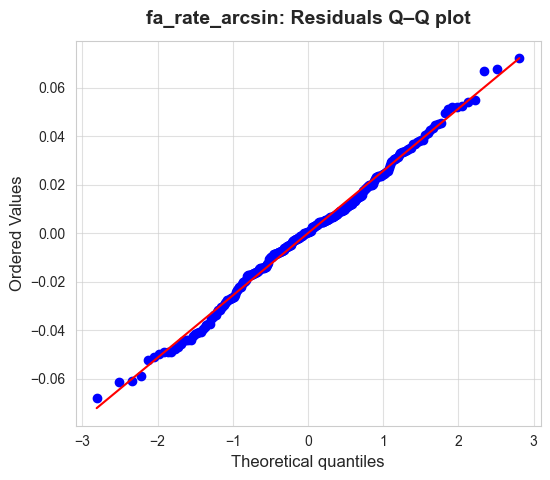

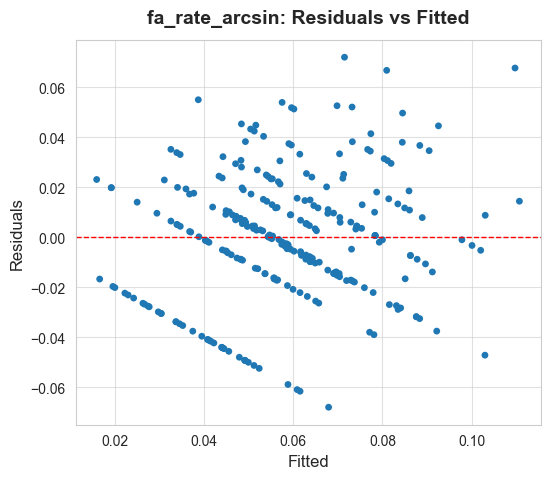

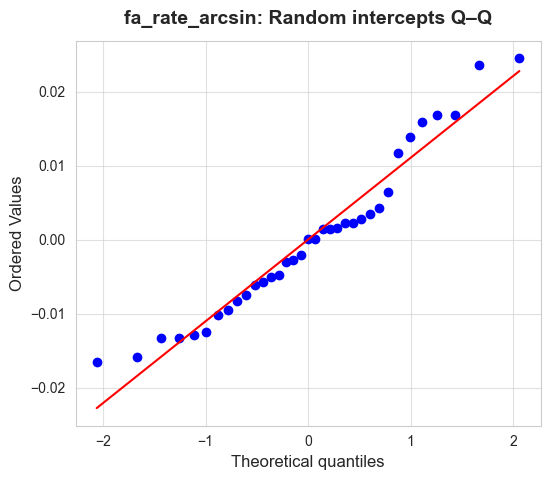

[Diag] {'shapiro_p': 0.3826979900513863, 'jb_p': 0.9990139016982907}


In [16]:

diag_stats = diag_lmm(res_fa, out_dir=out_dir, dv=dv, save_fig=False)
print("[Diag]", diag_stats)


### 事后分析

/Users/liyanyi/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/liyanyi/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/liyanyi/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


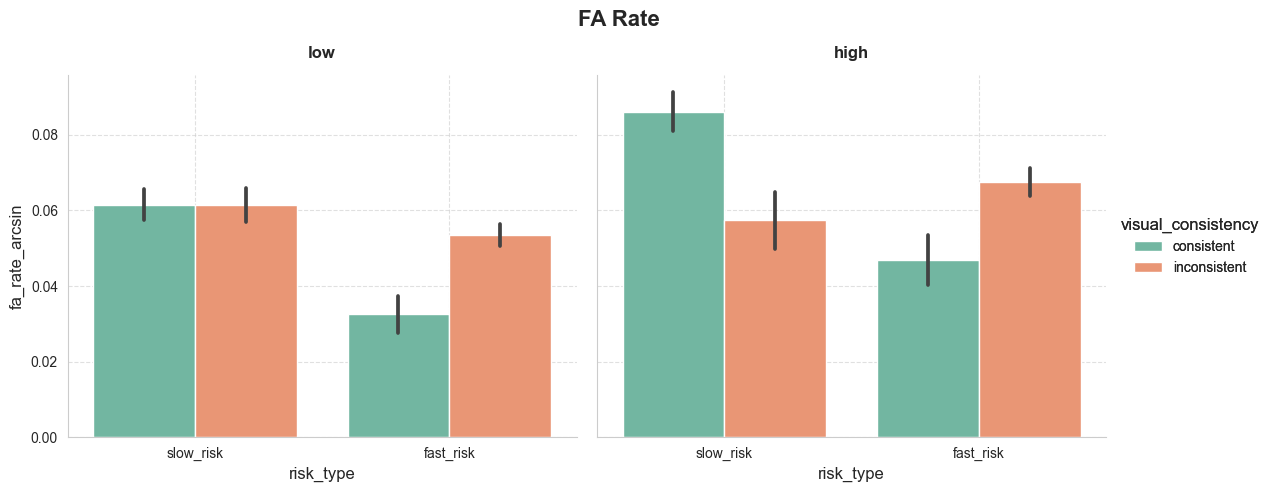

In [17]:

analysis_df = analysis_df.copy()
analysis_df['event_freq'] = analysis_df['event_freq'].astype('category')
analysis_df['risk_type'] = analysis_df['risk_type'].astype('category')
analysis_df['visual_consistency'] = analysis_df['visual_consistency'].astype('category')

analysis_df['event_freq'] = analysis_df['event_freq'].cat.set_categories(['low','high'], ordered=True)
analysis_df['risk_type'] = analysis_df['risk_type'].cat.set_categories(['slow_risk','fast_risk'], ordered=True)
analysis_df['visual_consistency'] = analysis_df['visual_consistency'].cat.set_categories(['consistent','inconsistent'], ordered=True)

# === 选择变量 ===
DV = 'fa_rate_arcsin'
F1, F2, F3 = 'event_freq', 'risk_type', 'visual_consistency'

# 清理缺失
data = analysis_df.dropna(subset=[F1, F2, F3, DV])

# === 柱状图 + SE 误差条（按第三因素分面）===
g = sns.catplot(
    data=data,
    kind='bar',
    x=F2, y=DV,
    hue=F3,
    col=F1,
    #order=['low','high'],
    #hue_order=['slow_risk','fast_risk'],
    palette='Set2',
    estimator=np.mean,
    errorbar=('se', 1),   # ±1 SEM
    dodge=True,
    height=5, aspect=1
)

# 轴标题与总标题
g.set_xlabels(f"{F2}")
g.set_ylabels(f"{DV}")
g.set_titles(col_template="{col_name}")

# 图例
g.add_legend(title=F3)

# 样式细节（学术期刊友好）
for ax in g.axes.flat:
    ax.grid(True, linestyle='--', alpha=0.6)
    sns.despine(ax=ax)

plt.subplots_adjust(top=0.85)
g.figure.suptitle(f"FA Rate", fontsize=16, fontweight='bold')

plt.show()


/Users/liyanyi/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/liyanyi/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/Users/liyanyi/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


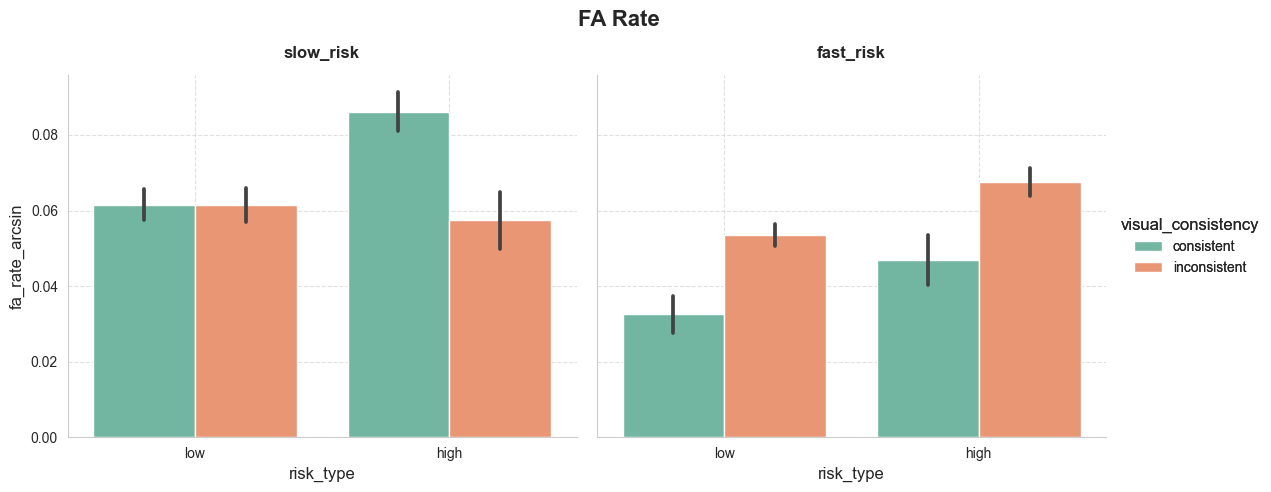

In [18]:

analysis_df = analysis_df.copy()
analysis_df['event_freq'] = analysis_df['event_freq'].astype('category')
analysis_df['risk_type'] = analysis_df['risk_type'].astype('category')
analysis_df['visual_consistency'] = analysis_df['visual_consistency'].astype('category')

analysis_df['event_freq'] = analysis_df['event_freq'].cat.set_categories(['low','high'], ordered=True)
analysis_df['risk_type'] = analysis_df['risk_type'].cat.set_categories(['slow_risk','fast_risk'], ordered=True)
analysis_df['visual_consistency'] = analysis_df['visual_consistency'].cat.set_categories(['consistent','inconsistent'], ordered=True)

# === 选择变量 ===
DV = 'fa_rate_arcsin'
F1, F2, F3 = 'event_freq', 'risk_type', 'visual_consistency'

# 清理缺失
data = analysis_df.dropna(subset=[F1, F2, F3, DV])

# === 柱状图 + SE 误差条（按第三因素分面）===
g = sns.catplot(
    data=data,
    kind='bar',
    x=F1, y=DV,
    hue=F3,
    col=F2,
    #order=['low','high'],
    #hue_order=['slow_risk','fast_risk'],
    palette='Set2',
    estimator=np.mean,
    errorbar=('se', 1),   # ±1 SEM
    dodge=True,
    height=5, aspect=1
)

# 轴标题与总标题
g.set_xlabels(f"{F2}")
g.set_ylabels(f"{DV}")
g.set_titles(col_template="{col_name}")

# 图例
g.add_legend(title=F3)

# 样式细节（学术期刊友好）
for ax in g.axes.flat:
    ax.grid(True, linestyle='--', alpha=0.6)
    sns.despine(ax=ax)

plt.subplots_adjust(top=0.85)
g.figure.suptitle(f"FA Rate", fontsize=16, fontweight='bold')

plt.show()


In [22]:


# 在 C 的每个水平做：
lvl_c = analysis_df["event_freq"].cat.categories[0]
d_sub  = analysis_df[analysis_df["event_freq"] == lvl_c].copy().dropna(subset=[DV,SUBJ,A,B])
res_sub = smf.mixedlm(f"{DV} ~ C({A},Sum)*C({B},Sum)", data=d_sub, groups=d_sub[SUBJ], re_formula="~1").fit()

# 1) EMMs 表（2×2 的四个均值与 CI）
emm = marginalmeans(res_sub, variables=[A, B])
print(emm)

# 2) 简单主效应（在 B 的每个水平比较 A 的两水平；Holm 校正）
cmp_A = comparisons(res_sub, variables=A, by=[B], p_adjust="holm")
print(cmp_A)

# 3) 或在 A 的每个水平比较 B
cmp_B = comparisons(res_sub, variables=B, by=[A], p_adjust="holm")
print(cmp_B)


NameError: name 'SUBJ' is not defined

## ACC

In [ ]:
df = analysis_df.copy()   # 用你的 DataFrame；若还没 add_block_factors，请先运行你写的 add_block_factors

if "hit_rate" in df.columns:        
    res_dp, df_dp = fit_lmm(df, dv='hit_rate', random_slopes=False, use_sum_contrast=True, reml=True)




=== LMM for hit_rate ===
                                                    Mixed Linear Model Regression Results
Model:                                         MixedLM                              Dependent Variable:                              hit_rate
No. Observations:                              279                                  Method:                                          REML    
No. Groups:                                    35                                   Scale:                                           0.0009  
Min. group size:                               7                                    Log-Likelihood:                                  519.6676
Max. group size:                               8                                    Converged:                                       Yes     
Mean group size:                               8.0                                                                                           
--------------------------------

/Users/liyanyi/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/liyanyi/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


# ANOVA 

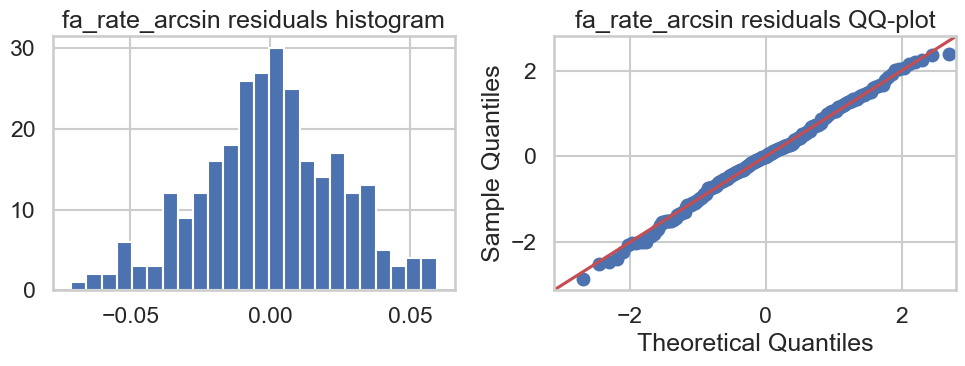

[正态] Shapiro p=0.4699 → 未见违背
[正态] Anderson–Darling p≈0.4023（统计量越小越正态）
[正态] Jarque–Bera p=0.6949
[独立] Durbin–Watson（全局）=2.258（≈2为独立；<2 正相关，>2 负相关）
[独立] 被试内 DW 中位数=2.131；DW<1.5 或 >2.5 的被试数=16/35

=== Type-III ANOVA ===
                                                      sum_sq     df  \
Intercept                                           0.020667    1.0   
C(participant_id)                                   0.073763   34.0   
C(event_freq, Sum)                                  0.010555    1.0   
C(risk_type, Sum)                                   0.018957    1.0   
C(visual_consistency, Sum)                          0.000725    1.0   
C(event_freq, Sum):C(risk_type, Sum)                0.000277    1.0   
C(event_freq, Sum):C(visual_consistency, Sum)       0.003690    1.0   
C(risk_type, Sum):C(visual_consistency, Sum)        0.021798    1.0   
C(event_freq, Sum):C(risk_type, Sum):C(visual_c...  0.003480    1.0   
Residual                                            0.174181  238.0   

 

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import normal_ad
import matplotlib.pyplot as plt

# ========== 帮助：拟合与获得残差 ==========
def _fit_rm_ols(df: pd.DataFrame, dv: str, use_sum_contrast: bool = True):
    """把被试作为固定因子，三因素+交互，返回 OLS 结果（用于残差/ANOVA 共用）"""
    d = df.dropna(subset=["participant_id","event_freq","risk_type","visual_consistency", dv]).copy()
    # 类型
    for c in ["event_freq","risk_type","visual_consistency"]:
        d[c] = d[c].astype("category")
    d["participant_id"] = d["participant_id"].astype(str)

    if use_sum_contrast:
        fe = "C(event_freq, Sum)*C(risk_type, Sum)*C(visual_consistency, Sum)"
    else:
        fe = "event_freq*risk_type*visual_consistency"

    formula = f"{dv} ~ C(participant_id) + {fe}"
    model = smf.ols(formula, data=d).fit()
    return model, d

# ========== A) 假设检验（正态 & 独立） ==========
def check_residual_assumptions(df: pd.DataFrame, dv: str,
                               order_cols=("participant_id","block_label"),
                               plot_qq: bool = True):
    """
    1) 用 OLS 拟合（等价 RM-ANOVA 的固定效应结构），取残差
    2) 正态性：Shapiro、Anderson–Darling、Jarque–Berra
    3) 独立性：Durbin–Watson（全局 + 分被试中位数）
    4) 可选：QQ plot + 直方图
    返回：tests（dict），by_subj_dw（DataFrame）
    """
    model, d = _fit_rm_ols(df, dv, use_sum_contrast=True)
    resid = pd.Series(model.resid, name="resid")

    # —— 正态性（全局残差）
    # Shapiro（n<=5000 最合适；n太大时改用 AD/JB 参考）
    try:
        sh_w, sh_p = stats.shapiro(resid.dropna())
    except Exception:
        sh_w, sh_p = np.nan, np.nan
    # Anderson–Darling（返回统计量及临界值；用 p≈）
    ad_stat, ad_p = normal_ad(resid.dropna())  # AD 越小越接近正态
    # Jarque–Bera
    jb_stat, jb_p, _, _ = sm.stats.stattools.jarque_bera(resid.dropna())

    # —— 独立性（按特定顺序拼接后做 DW）
    if order_cols is not None:
        d__ = d.copy()
        # 保障顺序稳定：参与者、block_label（若是类别则按类别序）
        for c in order_cols:
            if c in d__.columns and str(d__[c].dtype).startswith("category"):
                d__[c] = d__[c].cat.as_ordered()
        d__["resid"] = resid.values
        d__ = d__.sort_values(list(order_cols))
        dw_global = float(durbin_watson(d__["resid"].values))
    else:
        dw_global = float(durbin_watson(resid.values))

    # 分被试 DW（查看中位数 & 是否偏离 2）
    rows = []
    for pid, g in d.assign(resid=resid.values).groupby("participant_id"):
        if len(g) >= 3:
            rows.append({"participant_id": pid, "DW": float(durbin_watson(g["resid"].values))})
    by_subj_dw = pd.DataFrame(rows)
    dw_median = float(by_subj_dw["DW"].median()) if not by_subj_dw.empty else np.nan

    tests = {
        "Shapiro_W": float(sh_w), "Shapiro_p": float(sh_p),
        "AD_stat": float(ad_stat), "AD_p": float(ad_p),
        "JB_stat": float(jb_stat), "JB_p": float(jb_p),
        "DW_global": dw_global, "DW_median_by_subject": dw_median
    }

    # —— 可视化：残差直方图 + QQ
    if plot_qq:
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        axes[0].hist(resid, bins=24, edgecolor="white")
        axes[0].set_title(f"{dv} residuals histogram")
        sm.ProbPlot(resid, fit=True).qqplot(line="45", ax=axes[1])
        axes[1].set_title(f"{dv} residuals QQ-plot")
        plt.tight_layout(); plt.show()

    # —— 文本提示
    def _flag(p): return "不满足（p<.05）" if (not np.isnan(p) and p < 0.05) else "未见违背"
    print(f"[正态] Shapiro p={tests['Shapiro_p']:.4g} → {_flag(tests['Shapiro_p'])}")
    print(f"[正态] Anderson–Darling p≈{tests['AD_p']:.4g}（统计量越小越正态）")
    print(f"[正态] Jarque–Bera p={tests['JB_p']:.4g}")
    print(f"[独立] Durbin–Watson（全局）={tests['DW_global']:.3f}（≈2为独立；<2 正相关，>2 负相关）")
    if not by_subj_dw.empty:
        print(f"[独立] 被试内 DW 中位数={dw_median:.3f}；"
              f"DW<1.5 或 >2.5 的被试数="
              f"{int(((by_subj_dw['DW']<1.5)|(by_subj_dw['DW']>2.5)).sum())}/{len(by_subj_dw)}")

    return tests, by_subj_dw, model

# ========== B) RM-ANOVA（Type-III） ==========
def run_rm_anova(df: pd.DataFrame, dv: str, out_csv: str | None = None, use_sum_contrast: bool = True):
    """
    被试内 RM-ANOVA：被试=固定因子；三因素主效应+交互，Type-III
    返回：anova_tbl, model
    """
    model, d = _fit_rm_ols(df, dv, use_sum_contrast=use_sum_contrast)
    anova_tbl = sm.stats.anova_lm(model, typ=3)
    print("\n=== Type-III ANOVA ===")
    print(anova_tbl)
    if out_csv:
        anova_tbl.to_csv(out_csv, index=True, encoding="utf-8-sig")
        print(f"[保存] ANOVA 表已保存到：{out_csv}")
    return anova_tbl, model

# ================= 使用示例 =================
# 1) 先做假设检验（正态 & 独立），并画 QQ 图
tests_fa, dw_by_subj_fa, model_fa = check_residual_assumptions(
    analysis_df, dv="fa_rate_arcsin", order_cols=("participant_id","block_label"), plot_qq=True
)

# 2) 再做 RM-ANOVA，保存结果
anova_fa, model_fa2 = run_rm_anova(
    analysis_df, dv="fa_rate_arcsin", out_csv="anova_fa_rate_arcsin.csv", use_sum_contrast=True
)


# New LMM

In [23]:
import pandas as pd
import pingouin as pg
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm



ModuleNotFoundError: No module named 'pingouin'

In [2]:
install.packages("pingouin")

NameError: name 'install' is not defined